## Multi-step time series forecasting with XGBoost
- https://towardsdatascience.com/multi-step-time-series-forecasting-with-xgboost-65d6820bec39

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.6.21</div>
<div style="text-align: right"> Last update: 2023.6.21</div>

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline
# print(plt.stype.available)

# Options for pandas
pd.options.display.max_columns = 30

In [2]:
from typing import Tuple

from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error

In [3]:
spotprices = pd.read_csv("data/Elspotprices.csv", delimiter=";")
spotprices

,HourUTC,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR
0,2019-07-08 21:00,2019-07-08 23:00,NL,NaN,"34,630001"
1,2019-07-08 21:00,2019-07-08 23:00,FR,NaN,"34,630001"
2,2019-07-08 21:00,2019-07-08 23:00,AT,NaN,"34,630001"
3,2019-07-08 20:00,2019-07-08 22:00,FR,NaN,"39,430000"
4,2019-07-08 20:00,2019-07-08 22:00,NL,NaN,"39,430000"
...,...,...,...,...,...
307267,2021-12-21 16:00,2021-12-21 17:00,SE4,"4610,379883","620,000000"
307268,2021-12-21 16:00,2021-12-21 17:00,DE,"4610,379883","620,000000"
307269,2021-12-06 15:00,2021-12-06 16:00,SE3,"4655,379883","626,059998"
307270,2021-12-06 15:00,2021-12-06 16:00,SE4,"4655,379883","626,059998"


In [4]:
# Convert separator from "," to "." and make numeric
spotprices["SpotPriceEUR"] = spotprices["SpotPriceEUR"].str.replace(',', '.', regex=True)

spotprices["SpotPriceEUR"] = pd.to_numeric(spotprices["SpotPriceEUR"])

# Convert HourDK to proper date time and make it index
spotprices["HourDK"] = pd.to_datetime(spotprices["HourDK"])
spotprices.index = pd.to_datetime(spotprices["HourDK"])
# Discard all cols except DKK prices
spotprices = spotprices[["SpotPriceEUR"]]

# Order by ascending time stamp
spotprices.sort_values(by="HourDK", ascending=True, inplace=True)


In [5]:
spotprices = spotprices.resample(rule="1H").mean()

In [6]:
target_variable = "SpotPriceEUR"
timestamp_col = "HourDK"
target_sequence_length = 1*24
test_size = 0.20
first_day_test = "2021-01-01"
last_day_test = "2021-06-30"

hyperparameters = {
    "in_length" : 7*24,
    "step_size" : 12,
    "n_estimators" : 20,
    "max_depth" : 6,
    "subsample" : 0.5,
    "min_child_weight" : 1,
    "selected_features" : [target_variable]
    }

In [7]:
training_data = spotprices[spotprices.index < first_day_test]
training_data

,SpotPriceEUR
HourDK,
2017-01-01 00:00:00,23.577143
2017-01-01 01:00:00,23.505715
2017-01-01 02:00:00,22.278571
2017-01-01 03:00:00,21.102858
2017-01-01 04:00:00,21.591428
...,...
2020-12-31 19:00:00,45.024286
2020-12-31 20:00:00,42.802858
2020-12-31 21:00:00,40.445714


In [8]:
training_data = training_data.fillna(method='ffill')

In [9]:
test_data = spotprices[spotprices.index >= first_day_test]
test_data = test_data[test_data.index <= last_day_test]
test_data

,SpotPriceEUR
HourDK,
2021-01-01 00:00:00,36.028571
2021-01-01 01:00:00,34.557143
2021-01-01 02:00:00,32.840000
2021-01-01 03:00:00,31.932856
2021-01-01 04:00:00,30.860000
...,...
2021-06-29 20:00:00,80.175713
2021-06-29 21:00:00,78.312858
2021-06-29 22:00:00,76.512858


In [10]:
test_data = test_data.fillna(method='ffill')

In [11]:
def get_indices_entire_sequence(
    data: pd.DataFrame,
    window_size : int,
    step_size: int
) -> list:
    """
    sub-sequence를 만들기 위한 모든 start, end index를 생성한다.
    리턴 값은 (start_idx, end_idx)로 된 튜플의 리스트이다.
    이 튜플이 서브 시퀀스를 만드는 데 사용된다.

    Args:
        data (pd.DataFrame): _description_
        window_size (int): 서브시퀀스 길이. 입력길이 + 출력 길이, lookback 길이가 100이고 예측길이가 50이면 150으로 설정함
        step_size (int): 윈도우를 이동시키는 스텝의 크기

    Returns:
        indices : list of tuples
    """
    
    stop_position = len(data) -1 # 0부터 인덱스를 시적하므로
    
    subseq_first_idx = 0
        
    subseq_last_idx = window_size
        
    indices = []
    
    while subseq_last_idx <= stop_position:
        indices.append((subseq_first_idx, subseq_last_idx))
            
        subseq_first_idx += step_size
            
        subseq_last_idx += step_size

    return indices

In [12]:
training_indices = get_indices_entire_sequence(
    data = training_data,
    window_size=hyperparameters['in_length'] + target_sequence_length,
    step_size = hyperparameters['step_size']
)

In [13]:
training_indices

[(0, 192),
 (12, 204),
 (24, 216),
 (36, 228),
 (48, 240),
 (60, 252),
 (72, 264),
 (84, 276),
 (96, 288),
 (108, 300),
 (120, 312),
 (132, 324),
 (144, 336),
 (156, 348),
 (168, 360),
 (180, 372),
 (192, 384),
 (204, 396),
 (216, 408),
 (228, 420),
 (240, 432),
 (252, 444),
 (264, 456),
 (276, 468),
 (288, 480),
 (300, 492),
 (312, 504),
 (324, 516),
 (336, 528),
 (348, 540),
 (360, 552),
 (372, 564),
 (384, 576),
 (396, 588),
 (408, 600),
 (420, 612),
 (432, 624),
 (444, 636),
 (456, 648),
 (468, 660),
 (480, 672),
 (492, 684),
 (504, 696),
 (516, 708),
 (528, 720),
 (540, 732),
 (552, 744),
 (564, 756),
 (576, 768),
 (588, 780),
 (600, 792),
 (612, 804),
 (624, 816),
 (636, 828),
 (648, 840),
 (660, 852),
 (672, 864),
 (684, 876),
 (696, 888),
 (708, 900),
 (720, 912),
 (732, 924),
 (744, 936),
 (756, 948),
 (768, 960),
 (780, 972),
 (792, 984),
 (804, 996),
 (816, 1008),
 (828, 1020),
 (840, 1032),
 (852, 1044),
 (864, 1056),
 (876, 1068),
 (888, 1080),
 (900, 1092),
 (912, 1104),


In [14]:
def get_xgboost_x_y(
    indices: list,
    data: np.array,
    target_sequence_length,
    input_seq_len: int
) -> Tuple[np.array, np.array]:
    """_summary_

    Args:
        indices: List of index positions at which data should be sliced
        data: A univariate time series
        target_sequence_length: The forecasting horizon, m
        input_seq_len: The length of the model input, n

    Returns:
        all_x: np.array of shape (number of instances, input seq len)
        all_y: np.array of shape (number of instances, target seq len)
    """
    print("Preparing data...")
    
    for i, idx in enumerate(indices):
        data_instance = data[idx[0]: idx[1]]
        
        x = data_instance[0: input_seq_len]
        
        assert len(x) == input_seq_len
        
        y = data_instance[input_seq_len: input_seq_len + target_sequence_length]
        
        # Create all_y and all_x objects in first loop iteration
        if i == 0:

            all_y = y.reshape(1, -1)

            all_x = x.reshape(1, -1)

        else:

            all_y = np.concatenate((all_y, y.reshape(1, -1)), axis=0)

            all_x = np.concatenate((all_x, x.reshape(1, -1)), axis=0)

    print("Finished preparing data!")

    return all_x, all_y

In [15]:
X_train, y_train = get_xgboost_x_y(
    indices=training_indices, 
    data=training_data[hyperparameters["selected_features"]].to_numpy(),
    target_sequence_length=target_sequence_length,
    input_seq_len=hyperparameters["in_length"]
    )

Preparing data...
Finished preparing data!


In [16]:
X_train.shape

(2906, 168)

In [17]:
target_sequence_length

24

In [18]:
hyperparameters["in_length"]

168

In [19]:
y_train.shape

(2906, 24)

In [20]:
test_indices = get_indices_entire_sequence(
    data=test_data, 
    window_size=hyperparameters["in_length"]+target_sequence_length, 
    step_size=24
    )

X_test, y_test = get_xgboost_x_y(
    indices=test_indices, 
    data=test_data[hyperparameters["selected_features"]].to_numpy(),
    target_sequence_length=target_sequence_length,
    input_seq_len=hyperparameters["in_length"]
    )

Preparing data...
Finished preparing data!


모델 학습

In [21]:
model = xgb.XGBRegressor(
    n_estimators=hyperparameters["n_estimators"],
    max_depth=hyperparameters["max_depth"],
    subsample=hyperparameters["subsample"],
    min_child_weight=hyperparameters["min_child_weight"],
    objective="reg:squarederror",
    tree_method="hist"
    )

In [22]:
trained_model = MultiOutputRegressor(model).fit(X_train, y_train)
train_forecasts = trained_model.predict(X_train)

In [23]:
test_forecasts = trained_model.predict(X_test)
test_mae = mean_absolute_error(y_test, test_forecasts)
print(test_mae)
print("Mean test data value: {}".format(np.mean(y_test)))

9.119745010509876
Mean test data value: 49.52067473482659


In [24]:
test_forecasts.shape

(173, 24)

In [25]:
test_forecasts

array([[51.33255 , 49.358032, 46.134296, ..., 51.868946, 50.070435,
        43.17359 ],
       [50.33775 , 48.227394, 47.014038, ..., 45.952682, 53.762657,
        42.327908],
       [42.581825, 42.01338 , 36.12239 , ..., 37.668385, 41.648445,
        37.309273],
       ...,
       [65.97917 , 59.635956, 67.074196, ..., 74.25717 , 68.27619 ,
        71.42785 ],
       [67.51729 , 66.535484, 64.30254 , ..., 74.31862 , 69.91548 ,
        60.253777],
       [71.01396 , 67.74471 , 71.96229 , ..., 76.41391 , 66.37478 ,
        62.868046]], dtype=float32)

In [26]:
test_forecasts.flatten() # 학습할 떄 예측 구간만큼 이동했기 때문에 flatten 가능!! 중요!!

array([51.33255 , 49.358032, 46.134296, ..., 76.41391 , 66.37478 ,
       62.868046], dtype=float32)

In [27]:
fontsize = 16
plot_df = pd.DataFrame({"Forecasts" : test_forecasts.flatten(), "Targets" : y_test.flatten()}, index=range(len(y_test.flatten())))
plot_df

,Forecasts,Targets
0,51.332550,49.262857
1,49.358032,47.021429
2,46.134296,45.624285
3,45.754032,44.364284
4,50.371086,45.500000
...,...,...
4147,52.421143,82.798572
4148,55.393406,80.175713
4149,76.413910,78.312858
4150,66.374779,76.512858


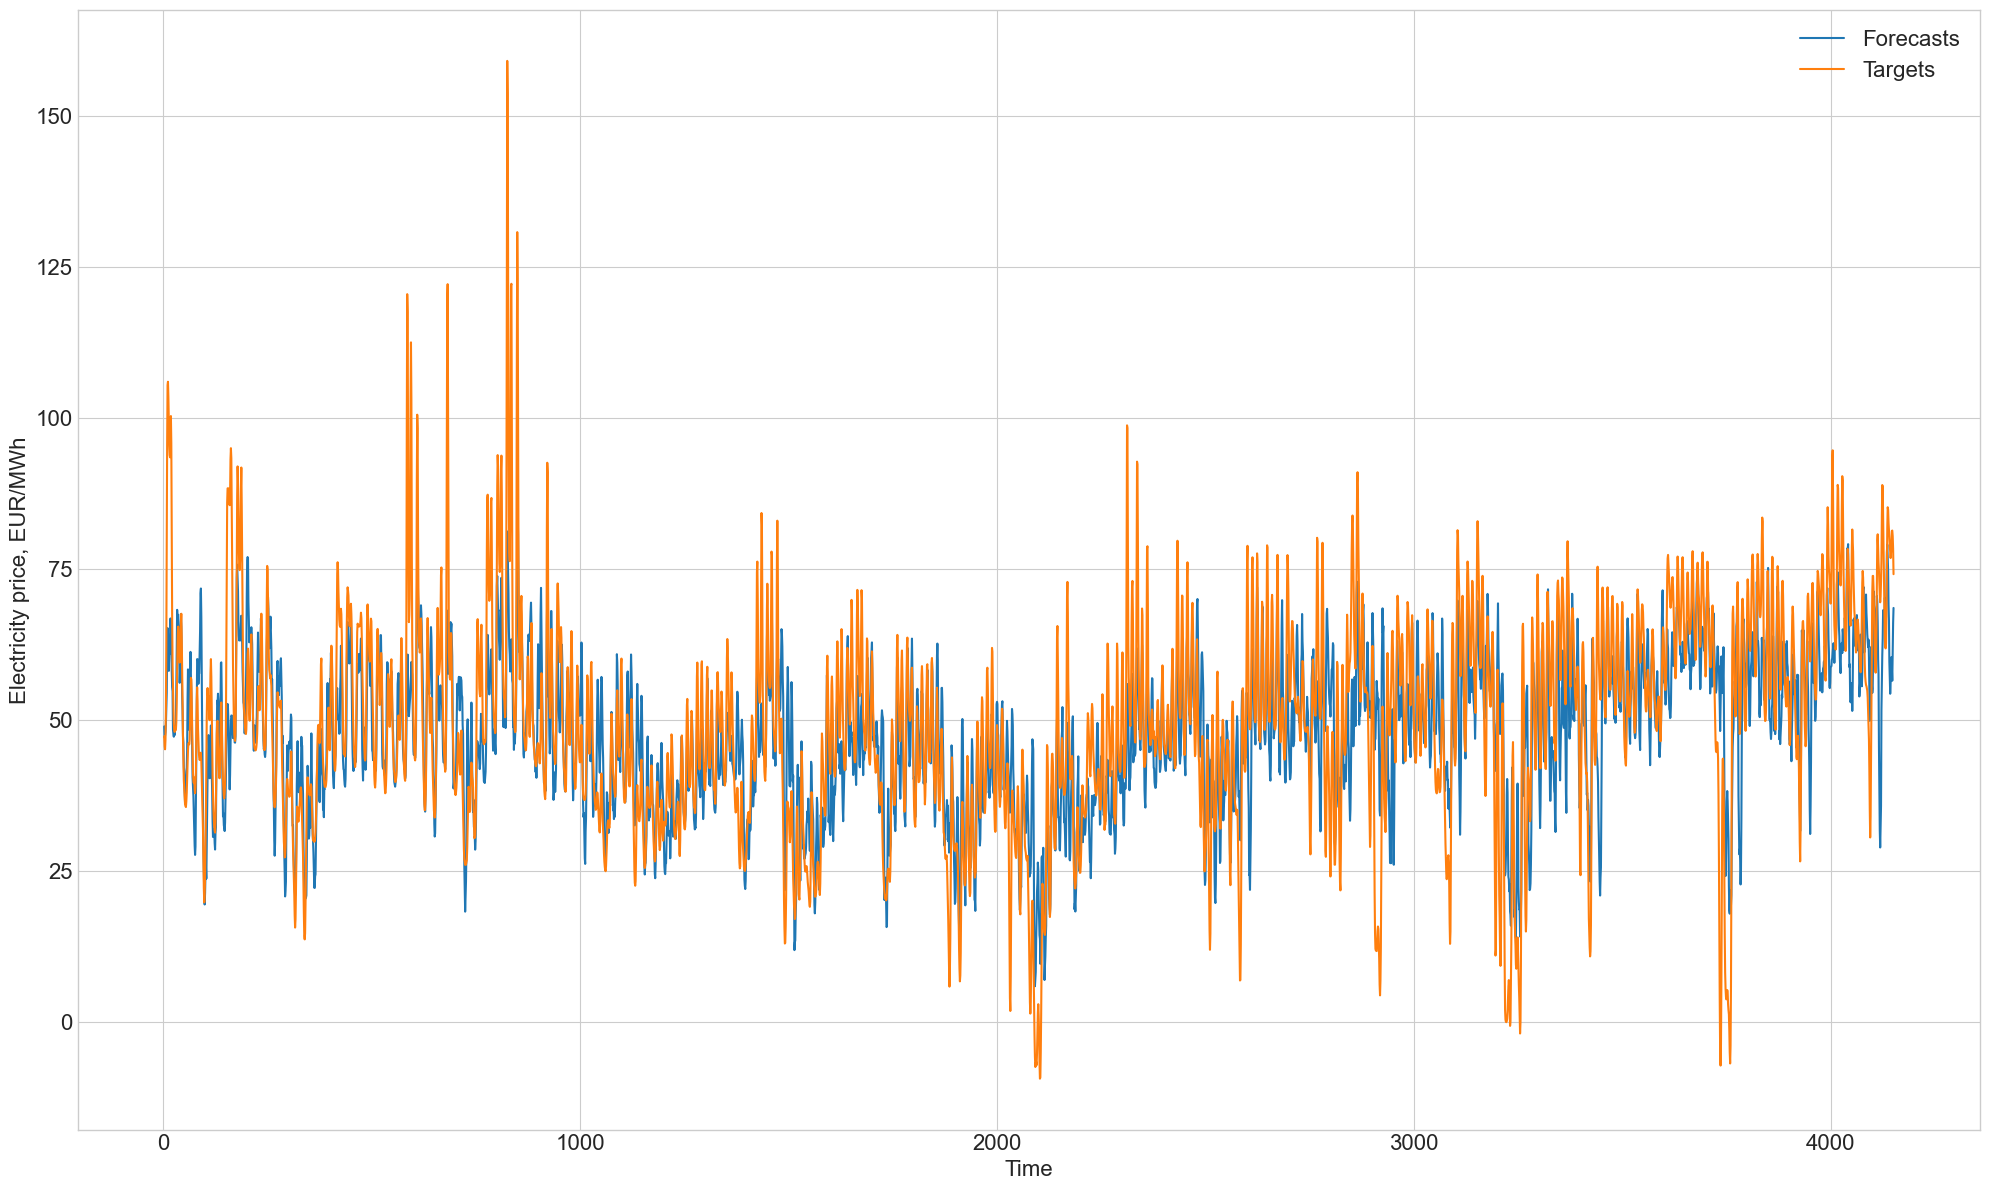

In [28]:
fig = plt.figure(figsize=(20,12))
plt.plot(plot_df.index, plot_df["Forecasts"].rolling(3).mean(), label="Forecasts")
plt.plot(plot_df.index, plot_df["Targets"].rolling(3).mean(), label="Targets")

plt.xlabel('Time', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel("Electricity price, EUR/MWh", fontsize=fontsize)
plt.grid(True)
plt.legend(fontsize=fontsize)
plt.tight_layout()